# Title :

---

## Introduction

lorem ipsum

## Methodology

lorem ipsum

### Preprocessing

In [1]:
# Import Library


import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [8]:
# Open dataset
df = xr.open_dataset("cru_ts4.09.1901.2024.tmp.dat.nc", engine="netcdf4") # lazy loading, tmp files
uk = gpd.read_file("geoBoundaries-GBR-ADM1-all/geoBoundaries-GBR-ADM1.shp").to_crs(epsg=4326) # uk boundaries shp
scot = uk[uk["shapeName"] == "Scotland"].dissolve() # dissolve to single polygon

minx, miny, maxx, maxy = scot.total_bounds
print("Lon:", minx, maxx, "Lat:", miny, maxy)
geom = scot.geometry.iloc[0]

pad = 0.15 # add some padding around the polygon to make sure we get all of it (and a bit of sea around)
minx1, maxx1 = minx - pad, maxx + pad
miny1, maxy1 = miny - pad, maxy + pad

df_scot = df.sel(lon=slice(minx1, maxx1), lat=slice(miny1, maxy1))
print(df_scot)

Lon: -8.645449000271071 -0.738072999669157 Lat: 54.63919599969569 60.843381000432885
<xarray.Dataset> Size: 7MB
Dimensions:  (time: 1488, lat: 13, lon: 17)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16
  * lat      (lat) float32 52B 54.75 55.25 55.75 56.25 ... 59.75 60.25 60.75
  * lon      (lon) float32 68B -8.75 -8.25 -7.75 -7.25 ... -1.75 -1.25 -0.75
Data variables:
    tmp      (time, lat, lon) float32 1MB ...
    stn      (time, lat, lon) float64 3MB ...
    mae      (time, lat, lon) float32 1MB ...
    maea     (time, lat, lon) float32 1MB ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:tmp.2503051121.dtb
    history:      Wed  5 Mar 13:28:04 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    

#### Datasets Description

1. <div align="justify"> `tmp` : The temperature variable `tmp` represents the monthly mean surface air temperature recorded at each grid cell across UK domain. Observations are provided on a regular latitude-longitude grid and span the period from January 1901 to December 2024. </div>
2. <div align="justify"> `lat`/`lon` : Latitude/Longitude </div>
3. <div align="justify"> `time` : The time dimension represents monthly observations spanning January 1901 to December 2024. Each timestamp corresponds to a monthly average temperature value.</div>
4. <div align="justify"> `stn` : The station count variable represents the number of observational weather stations contributing to the interpolation process used to estimate temperature at each grid cell. Higher station counts indicate stronger observational support and potentially lower uncertainty, whereas lower values suggest greater reliance on spatial interpolation and therefore increased uncertainty. For example, `stn` = 12 i.e. temperature estimate derived using data from 12 nearby stations.</div>



---

#### Exploring Temperature Across Scotland Region from 1901 to 2024

In [9]:
tmp = df_scot["tmp"]  # (time, lat, lon)

# ---- Create a boolean mask: True where grid cell center is inside Scotland ----
lon2d, lat2d = np.meshgrid(tmp["lon"].values, tmp["lat"].values)

try:
    # Shapely 2.x vectorized (fast if available)
    from shapely import vectorized
    mask2d = vectorized.contains(geom, lon2d, lat2d) | vectorized.touches(geom, lon2d, lat2d)
except Exception:
    # Fallback: slower point-in-polygon
    from shapely.prepared import prep
    from shapely.geometry import Point
    pg = prep(geom)
    mask2d = np.zeros(lon2d.shape, dtype=bool)
    for i in range(lat2d.shape[0]):
        for j in range(lon2d.shape[1]):
            mask2d[i, j] = pg.contains(Point(lon2d[i, j], lat2d[i, j])) or pg.touches(Point(lon2d[i, j], lat2d[i, j]))

mask = xr.DataArray(
    mask2d,
    dims=("lat", "lon"),
    coords={"lat": tmp["lat"], "lon": tmp["lon"]}
)

# ---- Area weights: cos(lat) ----
w_lat = np.cos(np.deg2rad(tmp["lat"]))
weights = xr.DataArray(w_lat, dims=("lat",), coords={"lat": tmp["lat"]}).broadcast_like(tmp.isel(time=0))

# IMPORTANT: weights must NOT contain NaNs -> set weights to 0 outside Scotland
weights_scot = weights.where(mask, 0.0)

# Data masked to Scotland (outside becomes NaN -> fine)
tmp_scot = tmp.where(mask)

# Scotland-wide area-weighted mean
scot_mean = tmp_scot.weighted(weights_scot).mean(("lat", "lon")).rename("scotland_tmp_mean")
print(scot_mean)

/var/folders/z4/28n4yxss0qs46l6xwc2t9t_r0000gn/T/ipykernel_2977/1765336921.py:9: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask2d = vectorized.contains(geom, lon2d, lat2d) | vectorized.touches(geom, lon2d, lat2d)
/var/folders/z4/28n4yxss0qs46l6xwc2t9t_r0000gn/T/ipykernel_2977/1765336921.py:9: DeprecationWarning: The 'shapely.vectorized.touches' function is deprecated and will be removed a future version. Use 'shapely.intersects_xy(geometry.boundary, x, y)' instead (available since shapely 2.0.0).
  mask2d = vectorized.contains(geom, lon2d, lat2d) | vectorized.touches(geom, lon2d, lat2d)


<xarray.DataArray 'scotland_tmp_mean' (time: 1488)> Size: 6kB
array([2.4566567, 1.0405531, 2.3961945, ..., 9.147893 , 5.785392 ,
       5.0935555], shape=(1488,), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0


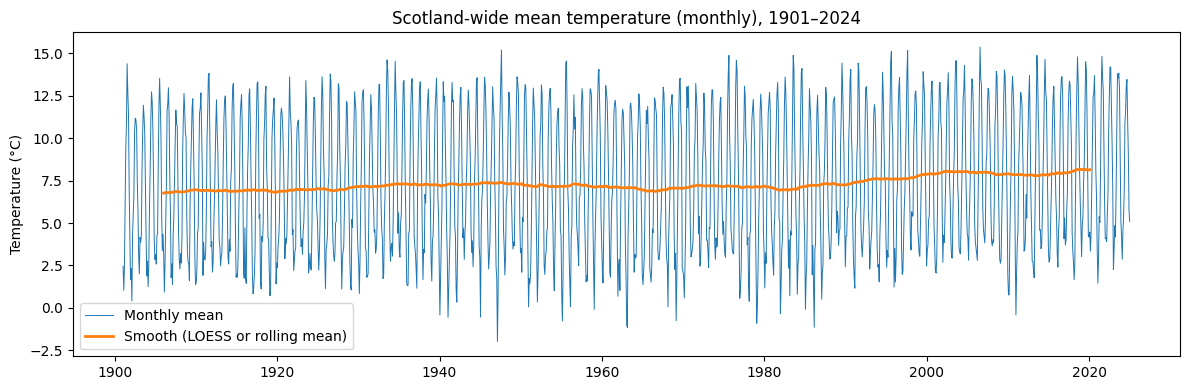

In [10]:
# Scotland-wide mean temperature time series + LOESS smoothing to show long-term trend
def smooth_loess(time_da, y, frac=0.08):
    """
    time_da: xarray time coordinate
    y: 1D numpy array
    frac: LOESS span (0-1). Larger = smoother
    """
    try:
        from statsmodels.nonparametric.smoothers_lowess import lowess
        x = np.arange(len(y))
        yhat = lowess(y, x, frac=frac, return_sorted=False)
        return yhat
    except Exception:
        # fallback: ~10-year rolling mean (monthly)
        return xr.DataArray(y, coords={"time": time_da}, dims=("time",)).rolling(time=120, center=True).mean().values

y = scot_mean.values
y_smooth = smooth_loess(scot_mean["time"], y, frac=0.08)

plt.figure(figsize=(12, 4))
plt.plot(scot_mean["time"].values, y, linewidth=0.7, label="Monthly mean")
plt.plot(scot_mean["time"].values, y_smooth, linewidth=2.0, label="Smooth (LOESS or rolling mean)")
plt.title("Scotland-wide mean temperature (monthly), 1901–2024")
plt.ylabel("Temperature (°C)")
plt.xlabel("")
plt.legend()
plt.tight_layout()
plt.show()

<div align="justify"> The Scotland-wide monthly mean temperature series exhibits a pronounced seasonal oscillation superimposed on a gradually increasing long-term mean. While the raw monthly values fluctuate strongly between winter and summer, the smoothed trend reveals a clear upward trajectory from the early 20th century to the present, with particularly accelerated warming after the 1980s. This pattern suggests that the dominant climate signal operates at a low temporal frequency rather than as a simple linear increase. Such nonlinearity motivates the use of a flexible temporal structure in the proposed Bayesian model, such as a random walk or spline-based latent trend component, rather than a strictly linear time effect. </div>

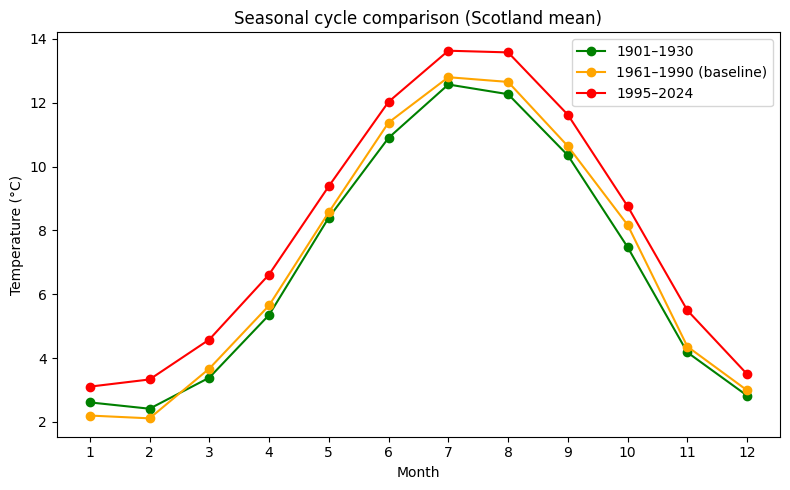

In [11]:
# seasonal cycle (climatology) comparison using WMO baseline (1961-1990)
# How far is each month relative to the reference climate? (baseline)
baseline = scot_mean.sel(time=slice("1961-01-01", "1990-12-31")) \
                    .groupby("time.month").mean("time")
early = scot_mean.sel(time=slice("1901-01-01", "1930-12-31")) \
                 .groupby("time.month").mean("time")

late = scot_mean.sel(time=slice("1995-01-01", "2024-12-31")) \
                .groupby("time.month").mean("time")

plt.figure(figsize=(8,5))
plt.plot(early["month"], early, marker="o", label="1901–1930", color= "green")
plt.plot(baseline["month"], baseline, marker="o", label="1961–1990 (baseline)", color = "orange")
plt.plot(late["month"], late, marker="o", label="1995–2024", color = "red")

plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.title("Seasonal cycle comparison (Scotland mean)")
plt.legend()
plt.tight_layout()
plt.show()

<div align="justify"> The seasonal cycle remains structurally stable across all three periods, with minimum in winter and maximum in summer occurring consistently in January-February and July-August, respectively. However, the more recent period (1995-2024) exhibits a systematic upward shift relative to both the early 20th century and the baseline period. The near-parallel displacement of the curves suggests that warming primarily acts as an additive shift to the annual cycle rather than altering its amplitude or timing. This justifies modelling temperature as the sum of a seasonal component and a temporally evolving mean, where seasonality can be represented using monthly fixed effects or harmonic terms within the hierarchical framework. </div>

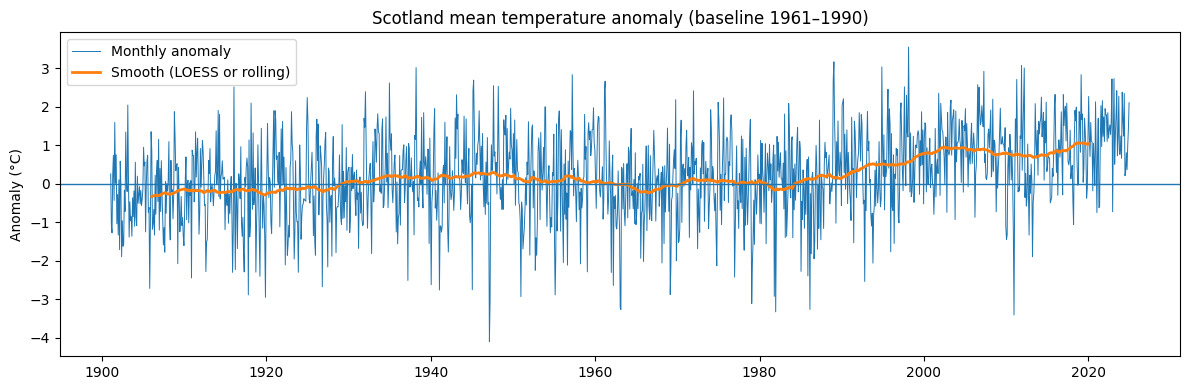

In [12]:
# Monthly anomalies relative to baseline climatology
anom = scot_mean.groupby("time.month") - baseline
anom = anom.rename("scotland_tmp_anom")

y_anom = anom.values
y_anom_smooth = smooth_loess(anom["time"], y_anom, frac=0.08)

plt.figure(figsize=(12, 4))
plt.plot(anom["time"].values, y_anom, linewidth=0.7, label="Monthly anomaly")
plt.plot(anom["time"].values, y_anom_smooth, linewidth=2.0, label="Smooth (LOESS or rolling)")
plt.axhline(0, linewidth=1)
plt.title("Scotland mean temperature anomaly (baseline 1961–1990)")
plt.ylabel("Anomaly (°C)")
plt.xlabel("")
plt.legend()
plt.tight_layout()
plt.show()

<div align="justify"> After removing the seasonal cycle, the anomaly series highlights persistent deviations from the historical climate normal. Early decades are characterised by predominantly negative or near-zero anomalies, whereas post-1990 observations are largely positive, indicating sustained warming relative to the baseline. The smoothed anomaly curve confirms a nonlinear increase, particularly pronounced in recent decades. By eliminating deterministic seasonality, the anomaly formulation isolates the long-term climatic signal, making it more suitable for hierarchical spatio-temporal modelling. This supports modelling the latent temporal trend directly on the anomaly scale, improving interpretability and reducing confounding between trend and seasonal effects. </div>

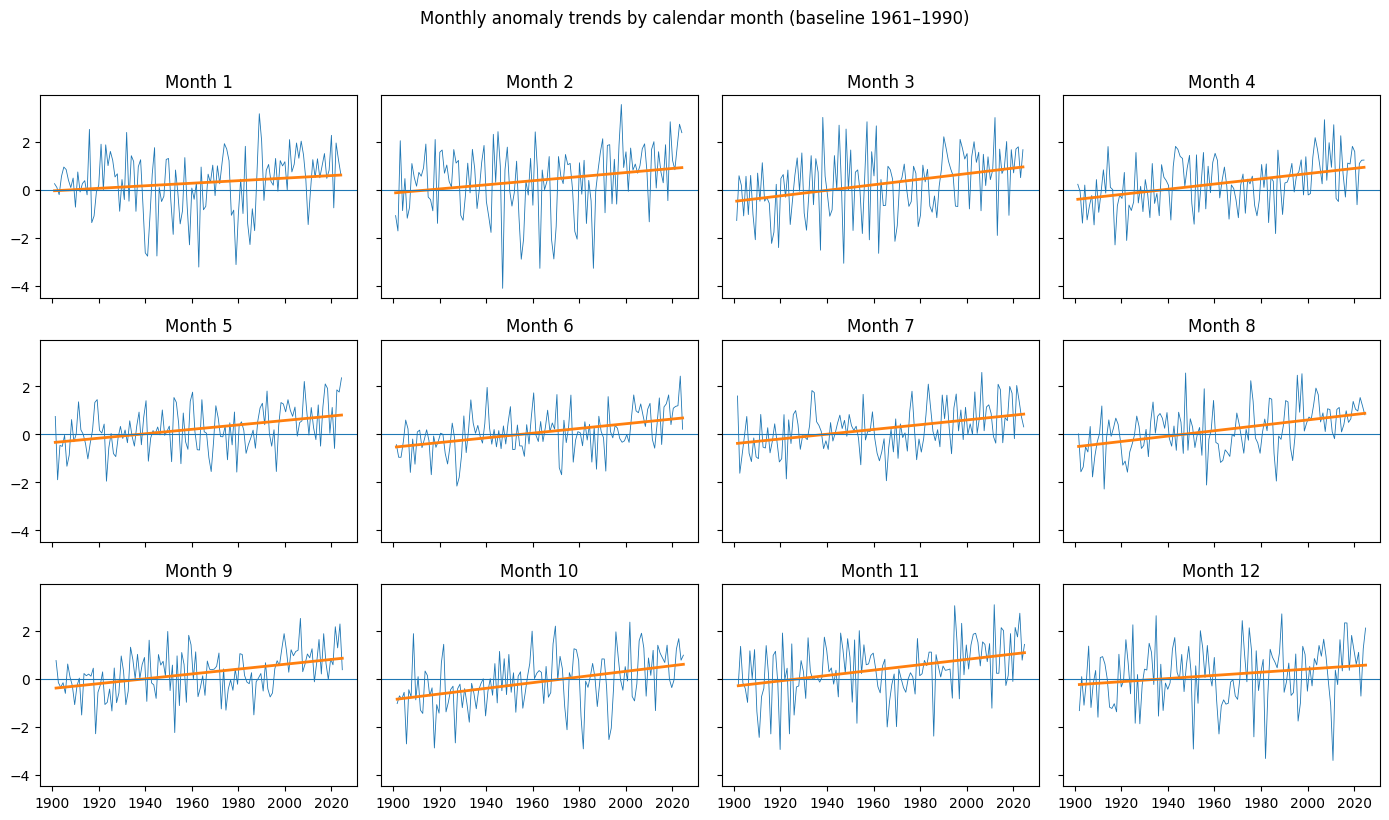

In [13]:
# trend by month (anomalies over time per month)
t = anom["time"]
year = (t.dt.year + (t.dt.dayofyear - 1) / 365.25).values  # approx

fig, axes = plt.subplots(3, 4, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.ravel()

for m in range(1, 13):
    ax = axes[m - 1]
    a_m = anom.where(anom["time.month"] == m, drop=True)

    # points/line
    ax.plot(a_m["time"].values, a_m.values, linewidth=0.6)

    # linear trend (quick diagnostic)
    yr_m = (a_m["time"].dt.year + (a_m["time"].dt.dayofyear - 1) / 365.25).values
    y_m = a_m.values
    ok = np.isfinite(yr_m) & np.isfinite(y_m)
    if ok.sum() > 2:
        b1, b0 = np.polyfit(yr_m[ok], y_m[ok], 1)  # y = b1*year + b0
        yfit = b1 * yr_m + b0
        ax.plot(a_m["time"].values, yfit, linewidth=2.0)

    ax.set_title(f"Month {m}")

fig.suptitle("Monthly anomaly trends by calendar month (baseline 1961–1990)", y=1.02)
for ax in axes:
    ax.axhline(0, linewidth=0.8)
plt.tight_layout()
plt.show()

<div align="justify"> The month-specific anomaly trends reveal positive slopes across all twelve calendar months, indicating that warming is a year-round phenomenon rather than seasonally confined. While the magnitude of increase varies modestly across months, no month exhibits a cooling tendency. This suggests that seasonal effects and long-term warming interact, but that the warming signal is broadly coherent across seasons. These findings motivate either a common temporal trend shared across months or, alternatively, a model allowing for month-specific slope deviations within a hierarchical structure. </div>

In [14]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# function to clip raster to polygon
def clip_raster_to_geom(ax, geom, collection_index=0):
    """Clip the first QuadMesh/collection produced by xarray.plot() to a (Multi)Polygon."""
    geoms = geom.geoms if geom.geom_type == "MultiPolygon" else [geom]
    vertices, codes = [], []

    for poly in geoms:
        x, y = poly.exterior.coords.xy
        verts = np.column_stack([x, y])
        c = np.full(len(verts), Path.LINETO, dtype=np.uint8)
        c[0] = Path.MOVETO
        vertices.append(verts)
        codes.append(c)

    vertices = np.vstack(vertices)
    codes = np.concatenate(codes)

    patch = PathPatch(Path(vertices, codes), transform=ax.transData)
    ax.collections[collection_index].set_clip_path(patch)

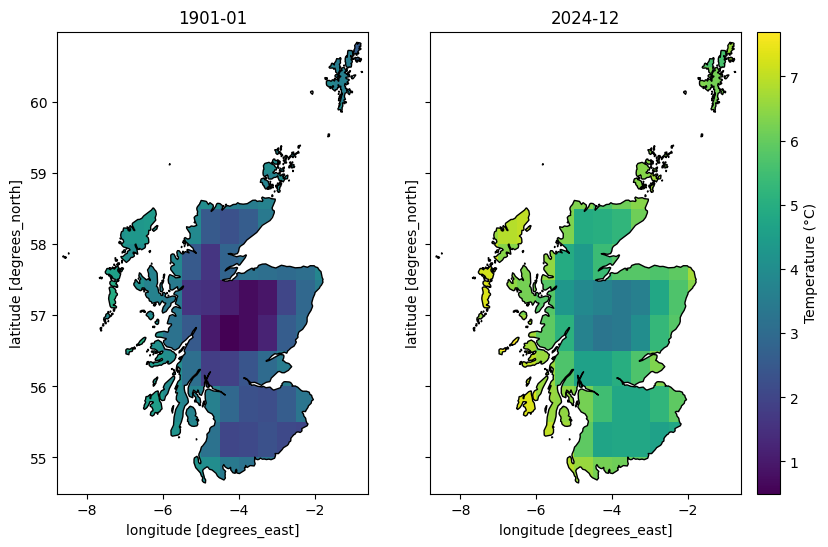

In [15]:
# Scotland comparison plot (1901-01 vs 1014-12) with clipped coastline
# pick two times
ds_0 = df_scot["tmp"].isel(time=0) # 1901-01
ds_n = df_scot["tmp"].isel(time=1487) # 2024-12

# compute shared color scale
vmin = float(min(ds_0.min(), ds_n.min()))
vmax = float(max(ds_0.max(), ds_n.max()))

# create side-by-side plots
fig, axes = plt.subplots(
    1, 2,
    figsize=(10, 6),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.05}
)

# first plot
im0 = ds_0.plot(
    ax=axes[0],
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False
)
axes[0].set_title("1901-01")

# second plot
im1 = ds_n.plot(
    ax=axes[1],
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False
)
axes[1].set_title("2024-12")

# clip both to Scotland
clip_raster_to_geom(axes[0], geom)
clip_raster_to_geom(axes[1], geom)

# draw boundary
scot.boundary.plot(ax=axes[0], color="black", linewidth=1)
scot.boundary.plot(ax=axes[1], color="black", linewidth=1)

# same extent
for ax in axes:
    ax.set_xlim(minx1, maxx1)
    ax.set_ylim(miny1, maxy1)

# shared colorbar
fig.colorbar(
    axes[1].collections[0],
    ax=axes,
    label="Temperature (°C)",
    fraction=0.04,
    pad=0.02
)

plt.show()



<div align="justify"> The spatial maps demonstrate a persistent geographical structure in temperature distribution, with relatively cooler inland regions and milder coastal zones. However, comparing 1901 and 2024 reveals a clear upward shift in the temperature field across all locations. Importantly, while the absolute level increases, the spatial pattern remains recognisable, indicating stable underlying spatial heterogeneity combined with temporal warming. This provides strong empirical justification for including spatial random effects in the proposed Bayesian framework to capture location-specific deviations from the overall temporal trend. </div> <br>

<div align="justify"> Taken together, the temporal and spatial analyses indicate that Scotland’s temperature evolution can be decomposed into four key components: a smooth long-term temporal trend, a stable seasonal cycle, persistent spatial structure, and potential space–time interaction. These exploratory findings directly motivate a Bayesian hierarchical spatio-temporal model in which temperature is expressed as the sum of temporal, seasonal, and spatial effects, with possible interaction terms to capture regional differences in warming rates.</div> <br>

---

#### Fitting the Model with a Bayesian Hierarchical Spatio-Temporal Model (with Seasonality)

Suppose temperature at spatial location $s$ and month $t$ is modelled as:

$$
y_{s,t} = \mu + f_{\text{space}}(s) + f_{\text{trend}}(t) + f_{\text{season}}(m_t) + f_{\text{interaction}}(s,t) + \epsilon_{s,t},
$$

where $m_t \in \{1,\dots,12\}$ denotes the month-of-year corresponding to time $t$.

Model components

- $\mu$: Global mean temperature level.

- $f_{\text{space}}(s)$: Spatial effect.  
  This captures persistent geographic variation across longitude and latitude, such as the coastal–inland contrast observed in Scotland. It is commonly modelled using a Gaussian Process (GP), often with a Matérn covariance function, to enforce spatial smoothness.

- $f_{\text{trend}}(t)$: Long-term temporal trend.  
  This represents systematic change over time (e.g., long-term warming). Depending on the specification, it may be modelled as a smooth function of time (e.g., random walk, spline, or GP) and/or include temporal dependence (e.g., AR(1)).

- $f_{\text{season}}(m_t)$: Seasonal (monthly) effect.  
  This captures the repeating annual cycle in monthly temperatures. A simple approach is to treat it as a month-of-year effect (12-level categorical term), optionally constrained to sum to zero for identifiability.

- $f_{\text{interaction}}(s,t)$: Spatio-temporal interaction effect.  
  This term allows the spatial pattern to evolve over time, enabling assessment of whether the coastal–inland contrast remains stable or changes across the study period.

- $\epsilon_{s,t}$: Observation noise.  
  This represents residual variation not explained by the spatial, trend, seasonal, or interaction components, and is typically assumed to be independent Gaussian noise with variance $\sigma^2$.

Hierarchical structure

This model is hierarchical because $f_{\text{space}}(s)$, $f_{\text{trend}}(t)$, $f_{\text{season}}(m_t)$, and $f_{\text{interaction}}(s,t)$ are treated as latent components with prior distributions. Their hyperparameters (e.g., spatial length-scale, trend smoothness or temporal correlation strength, seasonal variability, and interaction variance) are inferred from the data.

Overall, the model comprises multiple levels: (i) observed temperature measurements, (ii) latent spatial, temporal trend, seasonal, and spatio-temporal interaction components, and (iii) hyperparameters governing these components. This hierarchical structure enables joint inference on long-term warming trends, seasonal variation, persistent spatial contrasts, and potential evolution of spatial patterns over time.


##### 1️⃣ Checking whether temperature depends on time (temporal effect)

Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(0.00015660309523246596), z=np.float64(3.780357874864365), Tau=np.float64(0.0654118850829049), s=np.float64(72367.0), var_s=np.float64(366440363.6666667), slope=np.float64(0.000820591304668043), intercept=np.float64(6.9082392972455455))

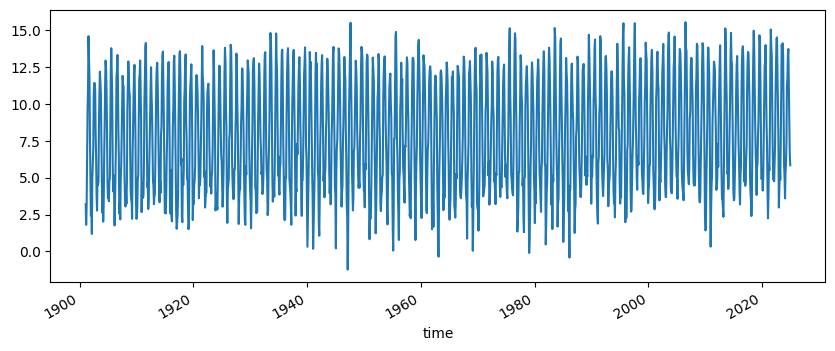

In [18]:
ts_mean = df_scot["tmp"].mean(dim=("lat","lon"))
ts = ts_mean.to_pandas()
ts.plot(figsize=(10,4))

import pymannkendall as mk
mk.original_test(ts)

<div align="justify">  The Mann–Kendall test was used to evaluate the presence of a monotonic trend in the temperature time series, supporting the modelling assumption that temperature exhibits temporal dependence. The results indicate a statistically significant monotonic trend (p = 0.00016), providing strong evidence against the null hypothesis of no temporal trend. </div>

##### 2️⃣ Checking whether temperature depends on region (spatial effect)

In [ ]:
import numpy as np
import libpysal
from esda.moran import Moran
import matplotlib.pyplot as plt

# Generate mean temperature over time
mean_map = df_scot["tmp"].mean(dim="time")

# latten temperature values and matching lon/lat grid
mean_temp = mean_map.values.flatten()
lon2d, lat2d = np.meshgrid(df_scot["lon"].values, df_scot["lat"].values)
coords = np.column_stack([lon2d.flatten(), lat2d.flatten()])

# Remove NaN 
mask = np.isfinite(mean_temp)          # keeps only non-NaN 
mean_temp_clean = mean_temp[mask]
coords_clean = coords[mask]

# Construct spatial weights
w = libpysal.weights.KNN.from_array(coords_clean, k=8)
w.transform = "r"

# Calculate Moran's I
mi = Moran(mean_temp_clean, w)

print("Moran's I:", mi.I)
print("p-value:", mi.p_sim)
print("Number of locations used:", len(mean_temp_clean))

<div align="justify"> Moran’s I was computed to assess spatial autocorrelation in the mean temperature map across Scotland. The statistic was 0.556 (p = 0.001), indicating strong and statistically significant positive spatial autocorrelation. This suggests that nearby grid cells exhibit similar temperature levels, confirming the presence of spatial clustering. These findings justify the inclusion of a spatial random effect in the hierarchical spatio-temporal model. </div>

##### 3 Checking whether temperature depends on season (seasonal effect)

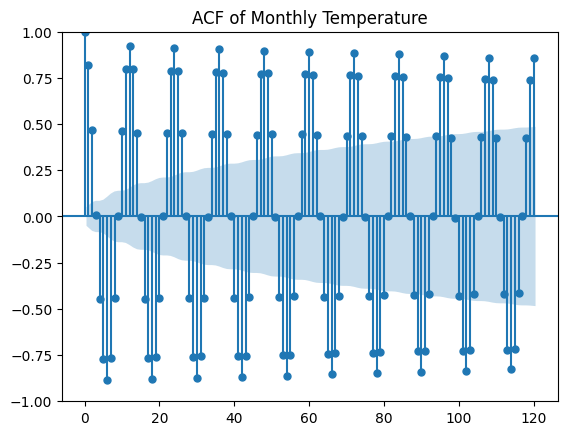

In [34]:
# first create an ACF plot to see if we notice any trends in seasonality among months

from statsmodels.graphics.tsaplots import plot_acf

ts_mean = df_scot["tmp"].mean(dim=("lat","lon"))

# plot full 1901–2024 and show 120 lags (10 years)
plot_acf(ts_mean, lags=120)
plt.title("ACF of Monthly Temperature")
plt.show()

-ACF line (lag) meaning: Each line at lag k shows the correlation between the time series and itself shifted by k months. 
-Blue band meaning: approximate 95% confidence intervals for the autocorrelations under the null hypothesis that the true autocorrelation at lag k is zero (no correlation). The takeaway is that bars outside the band indiciate significant autocorrelation.


Test monthly seasonality with F-test on month-of-year dummy variables:\
F-test is used to test whether a group of coefficeints is jointly equal to zero -> H0: beta_1 = beta_2 = ... = beta_12 = 0
If all monthly effects are zero, then we have no monthly seasonality. If we reject H0, at least one month differs.
This is a parametric test as it assumes residuals are roughly normal.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     1552.
Date:                Sat, 21 Feb 2026   Prob (F-statistic):               0.00
Time:                        18:00:24   Log-Likelihood:                -2165.6
No. Observations:                1488   AIC:                             4357.
Df Residuals:                    1475   BIC:                             4426.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6883      0.104     25.746      0.0

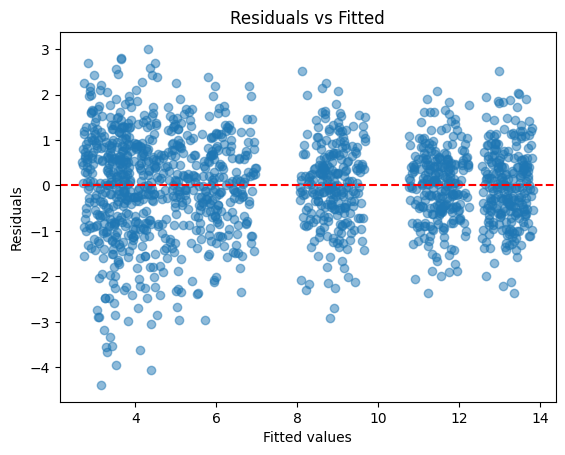

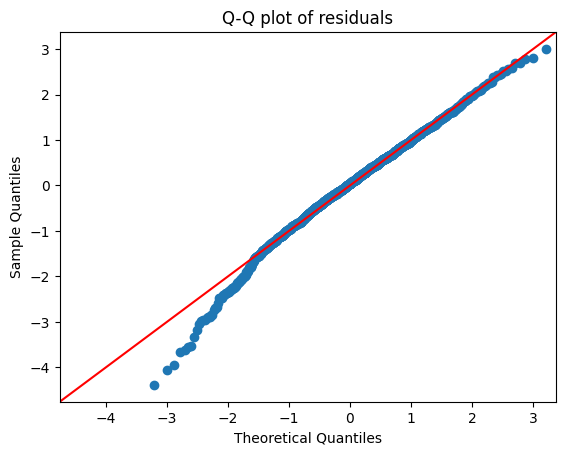

In [52]:
# carry out F-test on month-of-year dummy variables
import pandas as pd
import statsmodels.api as sm

# First, fit an OLS model on (a) linear trend (time_index) to account for any long-term increase or decrease in temperature over 1901–2024 (to avoid confounding long-term change with monthly seasonality),
# (b) Month-of-year dummy variables (11 dummies, February–December, with January as the baseline) to capture monthly seasonality, 
# and (c) an intercept (const) representing the baseline temperature (January at the start of the time series).

df = ts_mean.to_dataframe(name='temp').reset_index()
# Extract numeric temperature values, drop NaNs
y = df['temp'].values.astype(float)
mask = ~np.isnan(y)  # keep only valid rows
y = y[mask]
df = df.loc[mask].reset_index(drop=True)
# Month and time index
month = df['time'].dt.month.values.astype(int)
time_index = np.arange(len(df))
# Create month dummies (drop_first=True to avoid dummy trap)
month_dummies = pd.get_dummies(month, drop_first=True).astype(float)
# Combine predictors into X matrix
X = np.column_stack([np.ones(len(df)), time_index, month_dummies.values])  # add intercept
# Fit OLS
model = sm.OLS(y, X).fit()
# Summary
print(model.summary())

# Check model assumptions
resid = model.resid

# Residuals vs fitted
plt.scatter(model.fittedvalues, resid, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# Q-Q plot for normality
sm.qqplot(resid, line='45')
plt.title("Q-Q plot of residuals")
plt.show()


In [ ]:
# Conduct joint F-test on the month dummies alone to test if the monthly means differ
R = np.zeros((11, X.shape[1]))  # 11 month dummies
for i in range(11):
    R[i, i+2] = 1

f_test_months = model.f_test(R)
print("F-test for month dummies only:\n", f_test_months)
print("p-value:", f_test_months.pvalue)

Interpretation of results:

From the OLS, we see that 92.7% of the variation in spatially averaged monthly temperatures is captured by the combination of trend + monthly dummies.
This means these the OLS model, specifically the long-term trend and monthly features, captures both the long-term trend and the seasonal cycle very well, with little unexplained variance left. 
The subsequent F-test for the month-of-year dummy variables is very significant (F = 1678.4, p < 0.001), showing that mean temperatures differ systematically across months. 
This provides strong evidence of monthly seasonality in the dataset, with summer months substantially warmer and winter months colder relative to the baseline.

##### 4 Checking whether temperature depends on a spatio-temporal interation